This is a capstone project

We have to extract a table from the wikipedia page

link: "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [1]:
#importing pandas to read the data/table
import pandas as pd
import requests
from bs4 import BeautifulSoup

Let's extract the data from the website using request api

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
resp = requests.get(url).text

In [3]:
#Beautiful Soup to Parse the url page
soup = BeautifulSoup(resp, 'xml')

As we only need the  table which consists of the necessary data we will look for it using find method

In [4]:
#finding tables in the url page
table=soup.find('table')

In [5]:
column_names=['Postalcode','Borough','Neighbourhood']
df = pd.DataFrame(columns=column_names)

In [6]:
# extracting information from the table
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [7]:
df.head()

,Postalcode,Borough,Neighbourhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [8]:
# remove rows where Borough is 'Not assigned'
df=df[df['Borough']!='Not assigned']

In [9]:
# assign Neighbourhood=Borough where Neighbourhood is 'Not assigned'
df.loc[df['Neighbourhood']=="Not assigned",'Neighbourhood']=df.loc[df['Neighbourhood']=="Not assigned",'Borough']

At the location in dataframe in Neighborhood where Neighborhood is Not assigned we replaced it with Value in Borough in the same row

In [10]:
df.head()

,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [11]:
# group multiple Neighbourhood under one Postcode
temp_df=df.groupby('Postalcode')['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighbourhood':'Neighbourhood_joined'},inplace=True)

In [12]:
# join the newly constructed joined data frame
df_merge = pd.merge(df, temp_df, on='Postalcode')

In [13]:
# drop the Neighbourhood column
df_merge.drop(['Neighbourhood'],axis=1,inplace=True)

In [14]:
# drop duplicates from the data frame
df_merge.drop_duplicates(inplace=True)

In [15]:
# rename Neighbourhood_joined back to Neighbourhood
df_merge.rename(columns={'Neighbourhood_joined':'Neighbourhood'},inplace=True)

In [16]:
df_merge.head()

,Postalcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [17]:
df_merge.shape

(103, 3)

# Geoencoding

I have download the data of coordinates from the course itself using this link "https://cocl.us/Geospatial_data"

In [18]:
Geo_data = pd.read_csv("Geospatial_Coordinates.csv")

In [19]:
Geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [20]:
zipCodeDF_geo = df_merge.set_index('Postalcode').join(Geo_data.set_index('Postal Code')).reset_index()
zipCodeDF_geo.shape
zipCodeDF_geo.columns = ['Postalcode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']
zipCodeDF_geo

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558
101,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.636258,-79.498509


# Define Foursquare API

In [21]:
CLIENT_ID = 'XXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXX' # your Foursquare Secret
VERSION = '20200401' # Foursquare API version
LIMIT = 30
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('LIMIT:' + str(LIMIT))
print('Radius:' + str(radius))

Your credentails:
CLIENT_ID: GIW5UMML5MUTOZI20KD45YDCPG0QRYXMWVTEXGUL2UZNBSES
CLIENT_SECRET:HVQWUCNVO5QZQDNLXAGYPCYWN2TW1GX3YGAQWIKURQS0M4EJ
LIMIT:30
Radius:500


Let's extract the coordinates of the first instance in our dataset

In [22]:
torr_dt = zipCodeDF_geo.loc[0,'Neighborhood']
torr_dt

'Parkwoods'

In [23]:
#Coordinates of 'torr_dt'
torr_dt_lat = zipCodeDF_geo.loc[0,'Latitude']
torr_dt_long = zipCodeDF_geo.loc[0, 'Longitude']
print("Coordinates of {} in Torronto is {},{}".format(torr_dt,torr_dt_lat,torr_dt_long))

Coordinates of Parkwoods in Torronto is 43.7532586,-79.3296565


In [24]:
# create map of New York using latitude and longitude values
import folium
map_toronto = folium.Map(location=[torr_dt_lat, torr_dt_long], zoom_start=11)
map_toronto

In [25]:
# add markers to map
for lat, long, borough, neighbor in zip(zipCodeDF_geo['Latitude'],zipCodeDF_geo['Longitude'],zipCodeDF_geo['Borough'],zipCodeDF_geo['Neighborhood']):
    label = ('{}, {}'.format(neighbor,borough))
    label = folium.Popup(label, parse_html=False )
    folium.CircleMarker(
    [lat,long],
    radius=4,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#87cefa',
    fill_opacity=0.5,
    parse_html=False).add_to(map_toronto
    )

In [26]:
map_toronto

# Exploring Neighbourhood in Toronto
Using the following foursquare api query url, search venues on all boroughs in selected Toronto neighborhoods
https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&query=QUERY&radius=RADIUS&limit=LIMIT

In [27]:
# The following function retrieves the venues given the names and coordinates and stores it into dataframe.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, long in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            long,
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            long, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
toronto_venues = getNearbyVenues(names=zipCodeDF_geo['Neighborhood'],
                                   latitudes=zipCodeDF_geo['Latitude'],
                                   longitudes=zipCodeDF_geo['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern / Rouge
Don Mills
Parkview Hill / Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale
Rouge Hill / Port Union / Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood
Guildwood / Morningside / West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Thorncliffe Park
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Scarborough Village
Fairview / Henry Farm / Oriole
Northwood Park / York University
East Toronto
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
Kennedy Park / Ionview / East Birchmount Park
Bayview Village
Do

In [29]:
toronto_venues.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,GTA Restoration,43.753396,-79.333477,Fireworks Store
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [30]:
toronto_venues.shape

(1327, 7)

In [31]:
# add markers to map
for lat_2, long_2 in zip(toronto_venues['Venue Latitude'],toronto_venues['Venue Longitude']):
    
    folium.CircleMarker(
    [lat_2,long_2],
    radius=4,
    color='red',
    fill=True,
    fill_color='#87cefa',
    fill_opacity=0.5,
    parse_html=False).add_to(map_toronto
    )

In [32]:
map_toronto

This map shows the different venues located near the neighborhoods in toronto

Let's check how many venues were returned for each neighborhood

In [33]:
toronto_venues.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
Alderwood / Long Branch,9,9,9,9,9,9
Bathurst Manor / Wilson Heights / Downsview North,19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,25,25,25,25,25,25
...,...,...,...,...,...,...
Willowdale,37,37,37,37,37,37
Willowdale / Newtonbrook,1,1,1,1,1,1
Woburn,3,3,3,3,3,3


# Performing clustering on the neighborhoods

In [34]:
#using the KMeans Clustering
from sklearn.cluster import KMeans

In [35]:
X = zipCodeDF_geo[['Latitude','Longitude']]
X.head()

,Latitude,Longitude
0,43.753259,-79.329656
1,43.725882,-79.315572
2,43.654260,-79.360636
3,43.718518,-79.464763
4,43.662301,-79.389494


In [36]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [37]:
Sum_of_squared_distances = []
K = range(3,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

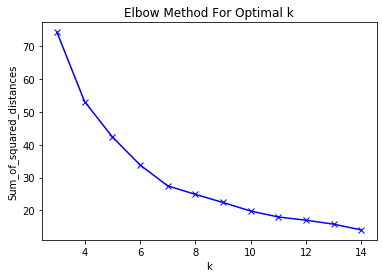

In [44]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

SCESS chnages drastically at 7 


so considering nunmber of clusters = 7

In [45]:
n_clusters = 7
cluster = KMeans(n_clusters=7,random_state = 0)
cluster.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [46]:
cluster.labels_

array([0, 6, 2, 5, 2, 1, 4, 0, 6, 2, 5, 1, 4, 6, 6, 2, 5, 1, 4, 6, 2, 5,
       4, 5, 2, 2, 4, 0, 0, 6, 2, 2, 4, 0, 3, 6, 2, 2, 6, 0, 3, 2, 2, 2,
       6, 0, 3, 6, 2, 3, 3, 6, 0, 3, 2, 5, 5, 3, 6, 0, 3, 5, 5, 1, 3, 4,
       0, 5, 5, 1, 3, 0, 0, 5, 2, 1, 1, 3, 4, 5, 2, 1, 0, 5, 2, 4, 5, 2,
       1, 3, 0, 2, 2, 1, 3, 4, 2, 2, 1, 2, 2, 1, 1])

In [47]:
zipCodeDF_geo.insert(0, 'Cluster Labels', cluster.labels_) #adding the labels into the dataframe

ValueError: cannot insert Cluster Labels, already exists

In [48]:
zipCodeDF_geo

,Cluster Labels,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,0,M3A,North York,Parkwoods,43.753259,-79.329656
1,6,M4A,North York,Victoria Village,43.725882,-79.315572
2,2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,5,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,2,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...,...
98,1,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653654,-79.506944
99,2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,2,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558
101,1,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.636258,-79.498509


In [49]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[torr_dt_lat,torr_dt_long],zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(zipCodeDF_geo['Latitude'], zipCodeDF_geo['Longitude'], zipCodeDF_geo['Neighborhood'], zipCodeDF_geo['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters